# Setup

In [2]:
# pip install fast_ml

In [3]:
# pip install pmdarima

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

# Import Data

In [5]:
# read csv files
df_west_raw = pd.read_csv('./drive/MyDrive/mids/w210/data/west_interval_data_01-29-2019_01-27-2021.csv')
df_east_raw = pd.read_csv('./drive/MyDrive/mids/w210/data/east_interval_data_01-29-2019_01-27-2021.csv')

# EDA

In [6]:
df_west_raw.count()

Service Agreement    104736
Start Date Time      104736
End Date Time        104736
Usage                104724
Usage Unit           104724
Cost                      0
Currency Unit             0
Avg. Temperature     104716
Temperature Unit     104736
Event Flags               6
Peak Demand          104724
Demand Unit          104724
dtype: int64

In [7]:
def clean_data(data):
  df = data.copy(deep=True)

  # drop columns
  df = df.drop(columns=['Usage Unit', 'Currency Unit', 'Temperature Unit', 'Demand Unit', 'Usage'])

  # mapper for column rename
  rename_mapper = {'Service Agreement':'service',
                 'Start Date Time':'start',
                 'End Date Time':'end',
                 'Cost':'cost',
                 'Avg. Temperature':'temp',
                 'Event Flags':'event_flag',
                 'Peak Demand':'demand'}
  # rename columns
  df = df.rename(mapper=rename_mapper, axis='columns')

  # convert columns to datetime
  df.start, df.end = pd.to_datetime(df.start), pd.to_datetime(df.end)

  # replace with missing values with previous value
  df.ffill(inplace=True)

  return df

In [8]:
df_west_clean = clean_data(df_west_raw)
df_west_clean.head()

,service,start,end,cost,temp,event_flag,demand
0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,NaN,54.0,NaN,844.8
1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,NaN,54.0,NaN,841.6
2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,NaN,54.0,NaN,832.0
3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,NaN,54.0,NaN,848.0
4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,NaN,55.0,NaN,812.8


In [9]:
# na_list = np.where(df_west_clean['demand'].isnull())[0]
# print(df_west_clean[na_list[0] - 10 : na_list[3] + 10])

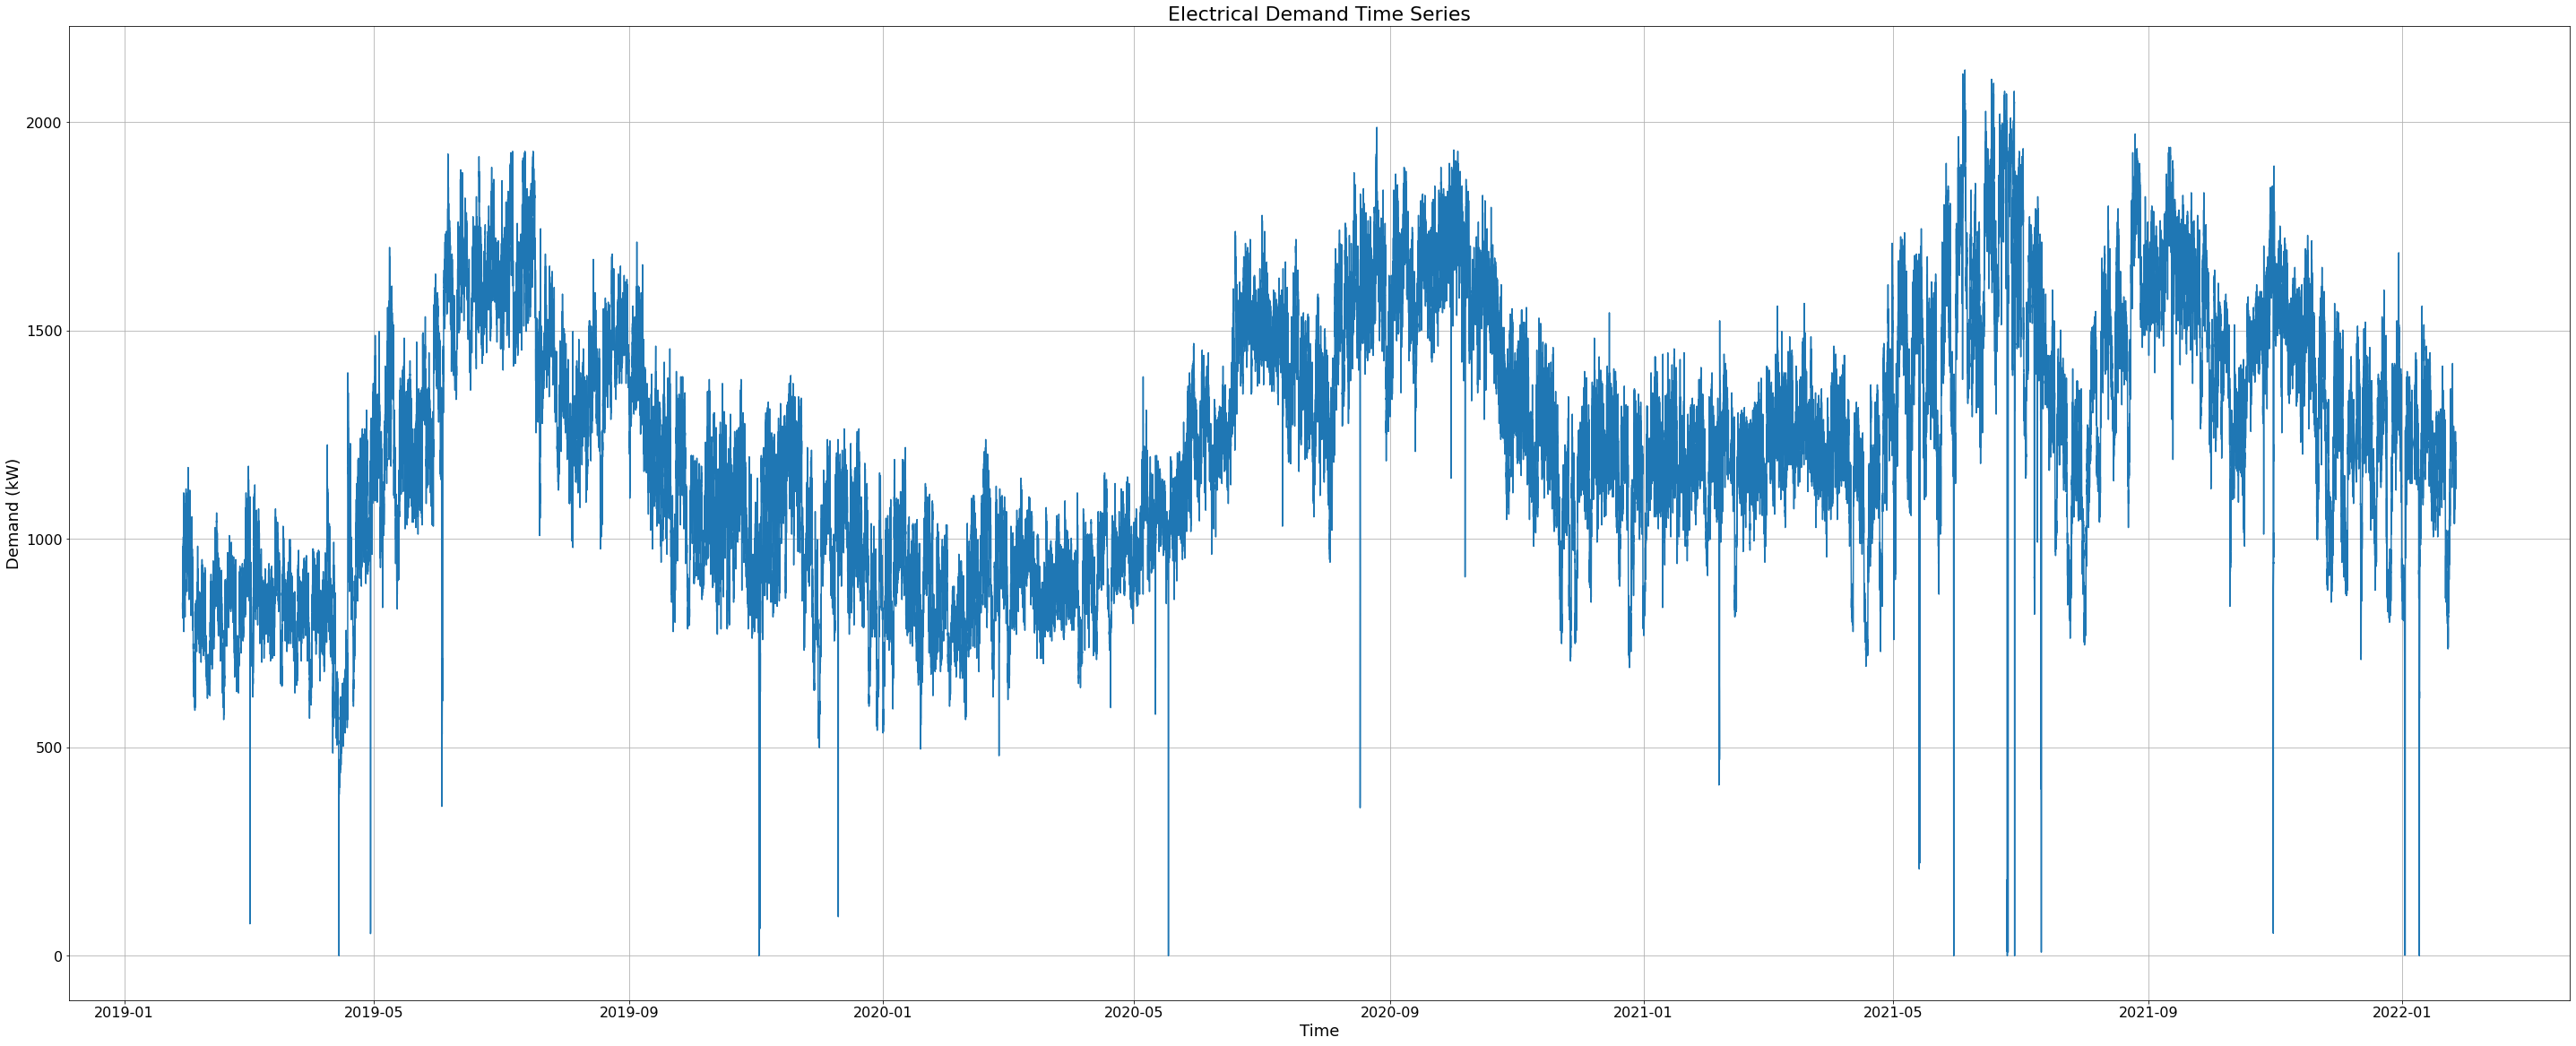

In [10]:
plt.rcParams['figure.figsize'] = (50, 20)
fig, ax = plt.subplots()

# add the time-series for "relative_temp" to the plot
ax.plot(df_west_clean.start, df_west_clean.demand)

# set title
ax.set_title("Electrical Demand Time Series", fontsize=22)

# set x-axis label
ax.set_xlabel("Time", fontsize=18)

# set y-axis label
ax.set_ylabel("Demand (kW)", fontsize=18)

# set xtick label
plt.xticks(fontsize=16)

# set ytick label
plt.yticks(fontsize=16)

ax.grid()

plt.show()

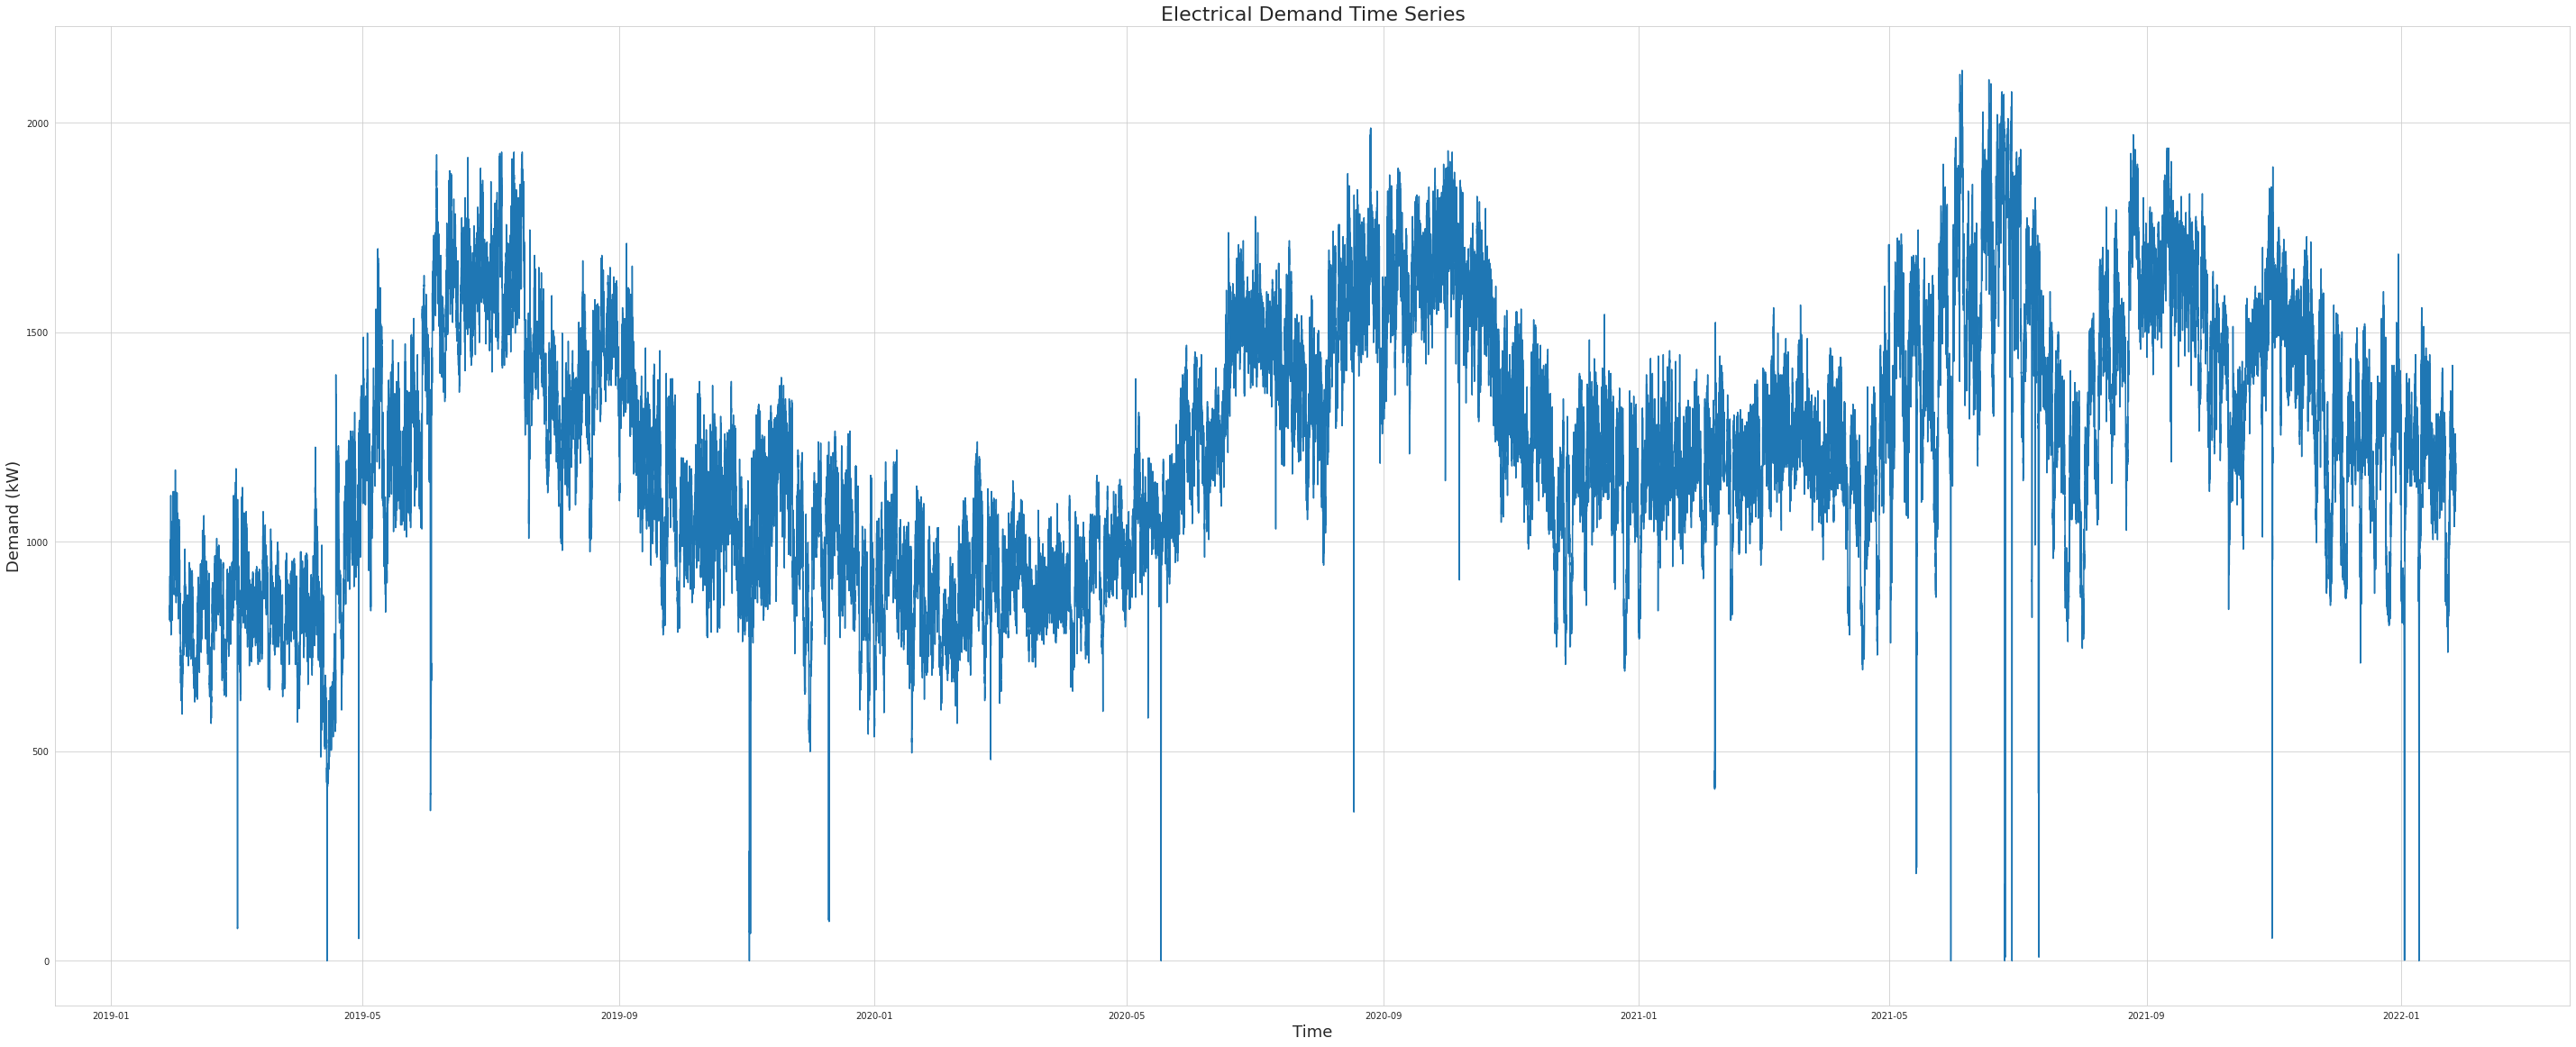

In [11]:
sns.set_style("whitegrid")
p = sns.lineplot(data=df_west_clean, x='start', y='demand')
p.set_title('Electrical Demand Time Series', fontsize=22)
p.set_xlabel('Time', fontsize=18)
p.set_ylabel('Demand (kW)', fontsize=18)
plt.show()

In [12]:
def feature_engineering(data):
  df = data.copy(deep=True)

  df['hour'] = df.start.dt.hour
  df['day'] = df.start.dt.dayofweek
  df['week'] = df.start.dt.isocalendar().week
  df['month'] = df.start.dt.month
  df['year'] = df.start.dt.year
  df['date'] = df.start.dt.date
  holidays = calendar().holidays(start=df.date.min(), end=df.date.max()).date
  df['holidays'] = df.date.isin(holidays)

  return df

In [13]:
df_west = feature_engineering(df_west_clean)
df_west.head()

,service,start,end,cost,temp,event_flag,demand,hour,day,week,month,year,date,holidays
0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,NaN,54.0,NaN,844.8,0,1,5,1,2019,2019-01-29,False
1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,NaN,54.0,NaN,841.6,0,1,5,1,2019,2019-01-29,False
2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,NaN,54.0,NaN,832.0,0,1,5,1,2019,2019-01-29,False
3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,NaN,54.0,NaN,848.0,0,1,5,1,2019,2019-01-29,False
4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,NaN,55.0,NaN,812.8,1,1,5,1,2019,2019-01-29,False


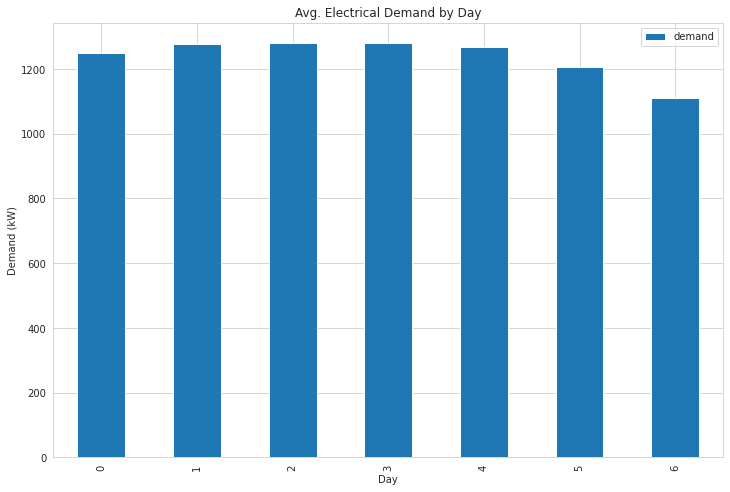

In [14]:
plt.rcParams['figure.figsize'] = (12, 8)
df_west[['day', 'demand']].groupby('day').mean().plot(kind='bar')
plt.title('Avg. Electrical Demand by Day')
plt.xlabel('Day')
plt.ylabel("Demand (kW)")
plt.show()

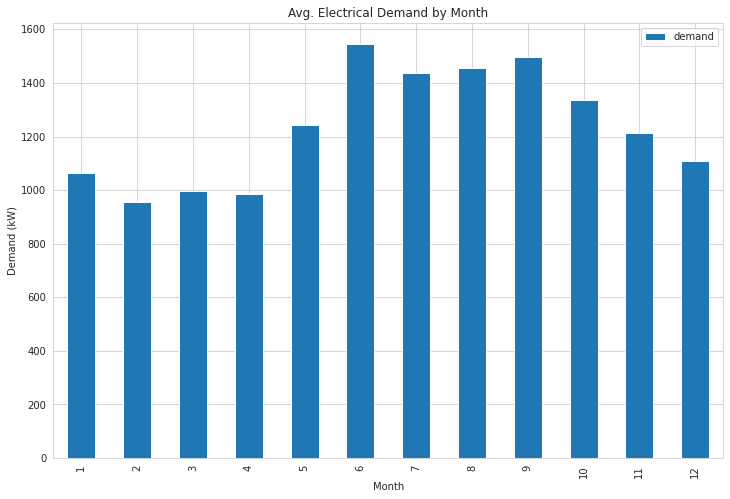

In [15]:
plt.rcParams['figure.figsize'] = (12, 8)
df_west[['month', 'demand']].groupby('month').mean().plot(kind='bar')
plt.title('Avg. Electrical Demand by Month')
plt.xlabel('Month')
plt.ylabel("Demand (kW)")
plt.show()

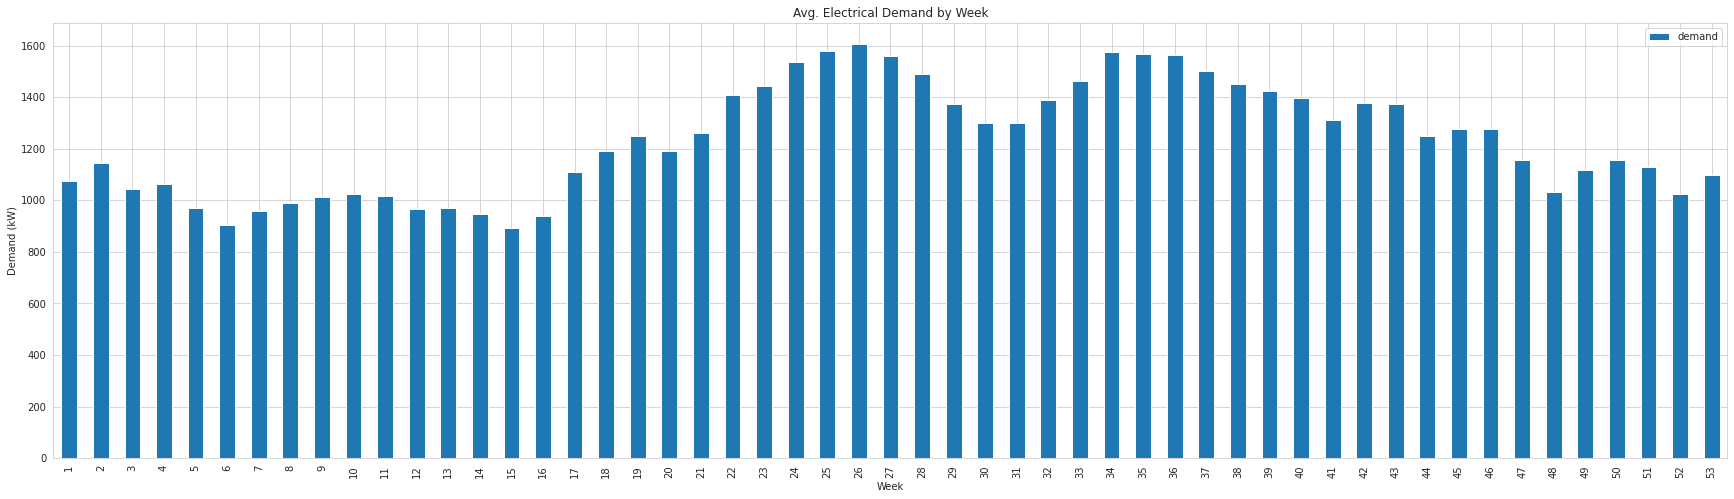

In [16]:
plt.rcParams['figure.figsize'] = (30, 8)
df_west[['week', 'demand']].groupby('week').mean().plot(kind='bar')
plt.title('Avg. Electrical Demand by Week')
plt.xlabel('Week')
plt.ylabel("Demand (kW)")
plt.show()

In [17]:
df_west_split = df_west.drop(columns=['cost', 'event_flag']).copy()
df_ts = df_west[['start', 'demand']]

# Time-Series

In [18]:
df_ts.index = df_ts['start']
del df_ts['start']
print(df_ts.head())

                     demand
start                      
2019-01-29 00:00:00   844.8
2019-01-29 00:15:00   841.6
2019-01-29 00:30:00   832.0
2019-01-29 00:45:00   848.0
2019-01-29 01:00:00   812.8


In [19]:
rolling_mean = df_ts.rolling(672).mean()
rolling_std = df_ts.rolling(672).std()

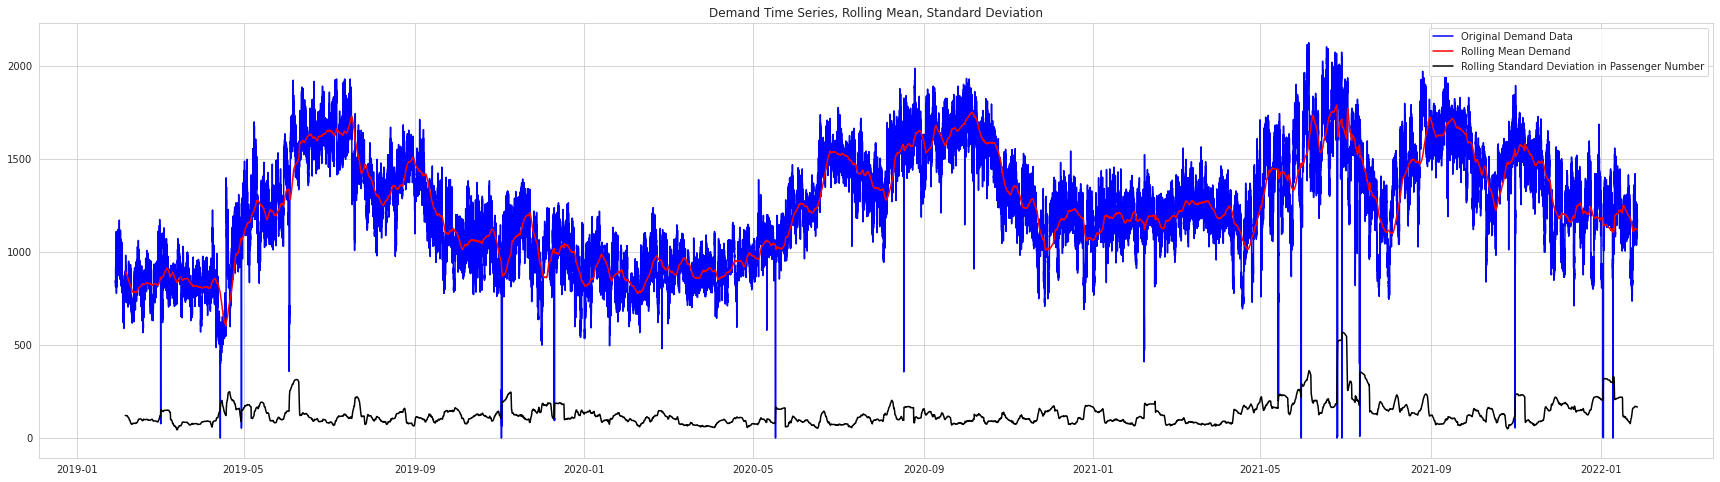

In [20]:
plt.plot(df_ts, color="blue",label="Original Demand Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Demand")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Demand Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

In [21]:
# adft = adfuller(df_ts,autolag="AIC")

# output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
# print(output_df)

In [23]:
autocorrelation_lag1 = df_ts['demand'].autocorr(lag=672)
print("One Week Lag: ", autocorrelation_lag1)

autocorrelation_lag1 = df_ts['demand'].autocorr(lag=672*2)
print("Two Week Lag: ", autocorrelation_lag1)

autocorrelation_lag1 = df_ts['demand'].autocorr(lag=672*3)
print("Three Week Lag: ", autocorrelation_lag1)

autocorrelation_lag1 = df_ts['demand'].autocorr(lag=672*4)
print("Four Week Lag: ", autocorrelation_lag1)

One Week Lag:  0.7869776603458432
Two Week Lag:  0.7161141503779436
Three Week Lag:  0.6462085119197324
Four Week Lag:  0.5891410930078934


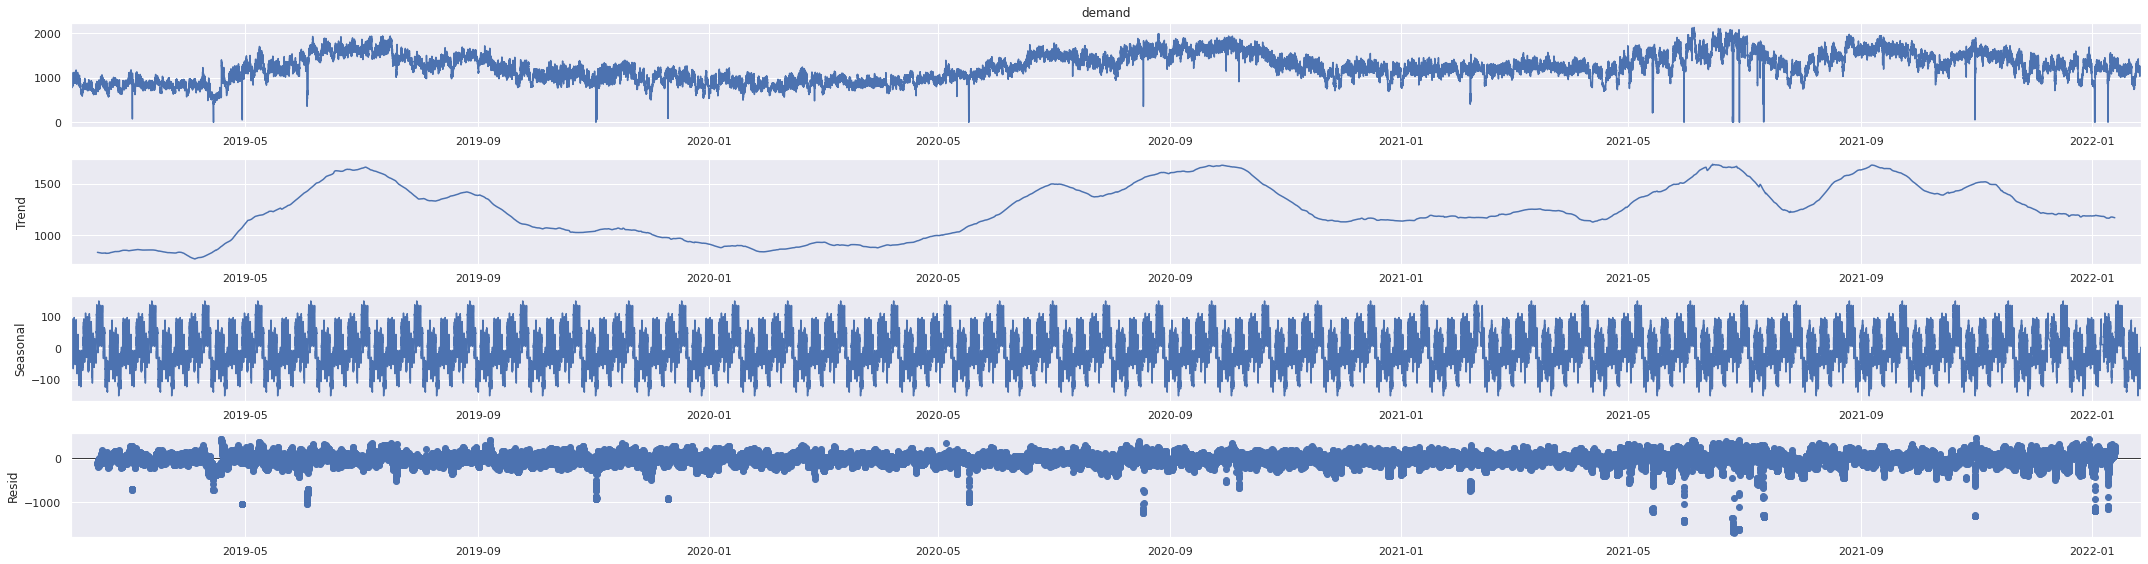

In [28]:
decompose = seasonal_decompose(df_ts['demand'], model='additive', period=4*24*7*4)
decompose.plot()
plt.show()

In [25]:
def split_data_ts(df_ts):
  df = df_ts.copy()

  train_size = 0.9
  valid_size = 0.05

  train_index = int(len(df)*train_size)
  valid_index = int(len(df)*valid_size)

  df_train = df[0:train_index]
  df_valid = df[train_index : train_index + valid_index]
  df_test = df[train_index + valid_index : ]

  return df_train, df_valid, df_test

In [26]:
# split time series data
train_ts, valid_ts, test_ts = split_data_ts(df_ts)

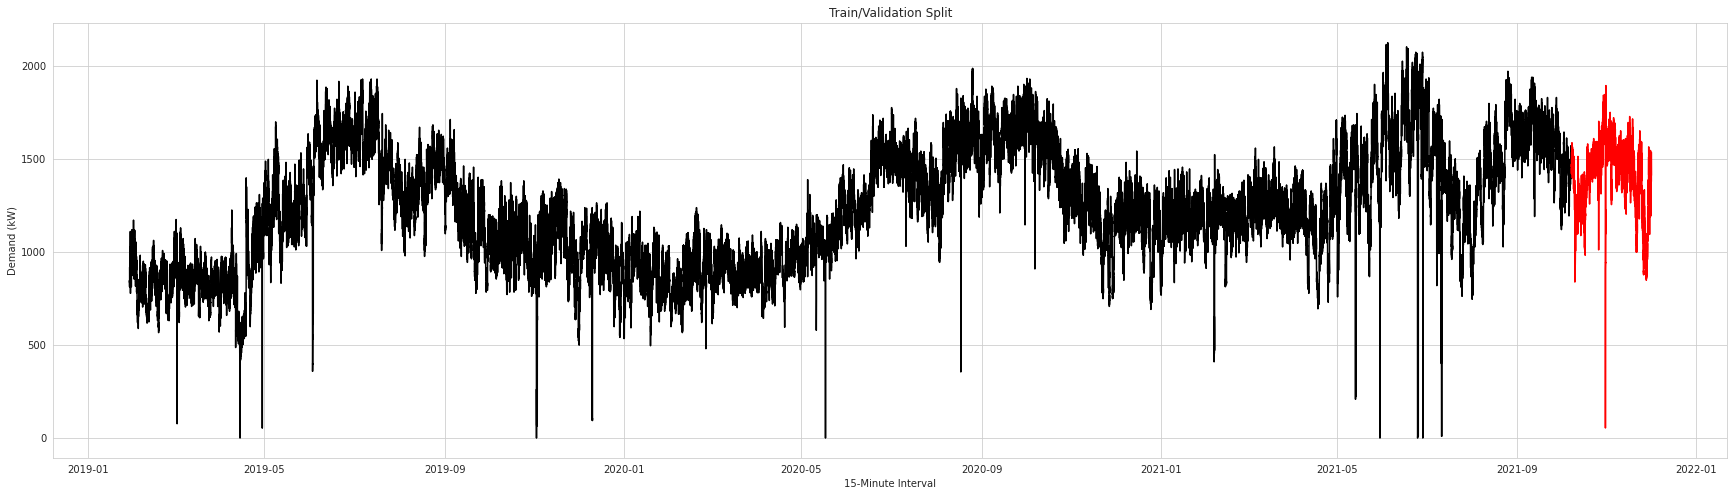

In [27]:
plt.plot(train_ts, color="black")
plt.plot(valid_ts, color='red')
plt.title('Train/Validation Split')
plt.ylabel('Demand (kW)')
plt.xlabel('15-Minute Interval')
sns.set()
plt.show()

In [30]:
# model = auto_arima(train_ts, trace=True, error_action='ignore', suppress_warnings=True)
# model.fit(train_ts)
# forecast = model.predict(n_periods=len(valid_ts))
# forecast = pd.DataFrame(forecast,index = valid_ts.index,columns=['Prediction'])

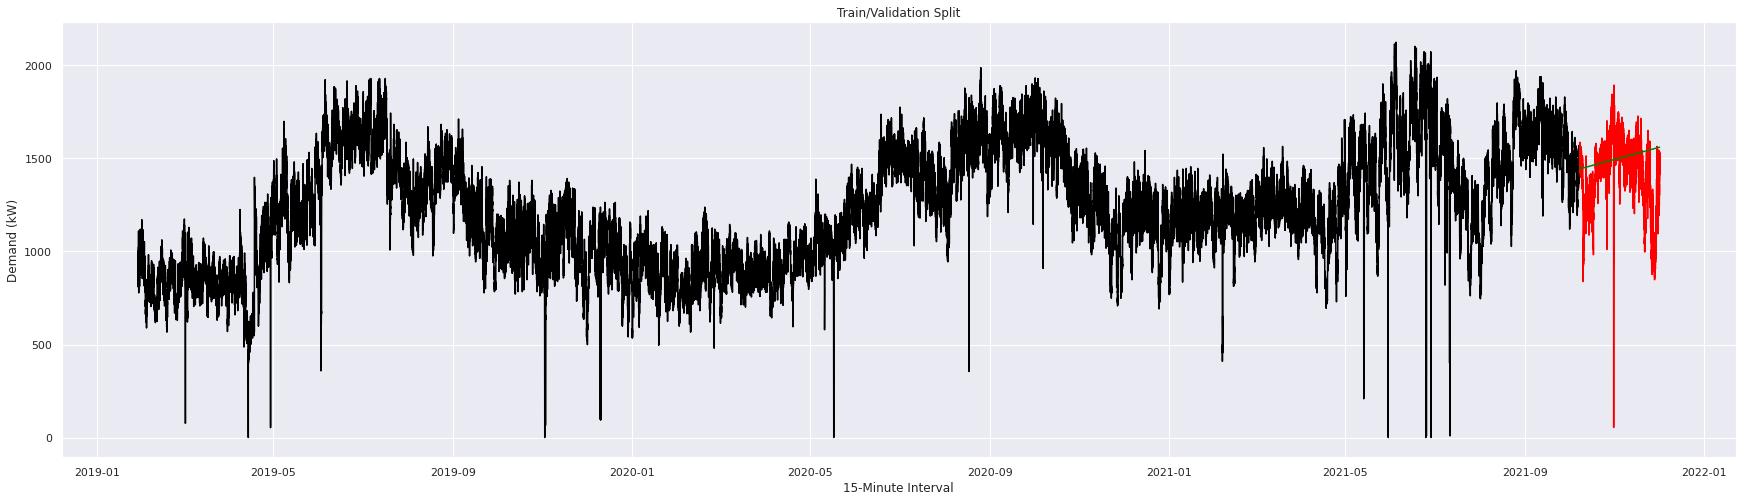

In [34]:
plt.plot(train_ts, color="black")
plt.plot(valid_ts, color='red')
plt.plot(forecast, color='green')
plt.title('Train/Validation Split')
plt.ylabel('Demand (kW)')
plt.xlabel('15-Minute Interval')
sns.set()
plt.show()

# Split Data

In [28]:
# def split_data(df):
#   train_size = 0.8
#   valid_size = 0.1
#   train_index = int(len(df*train_size))

#   df_train = df[0:train_index]
#   df_rem = df[train_index:]

#   valid_index = int(len(df)*valid_size)

#   df_valid = df[train_index:train_index+valid_index]
#   df_test = df[train_index+valid_index:]

#   X_train, y_train = df_train.drop(columns='demand').copy(), df_train['demand'].copy()
#   X_valid, y_valid = df_valid.drop(columns='demand').copy(), df_valid['demand'].copy()
#   X_test, y_test = df_test.drop(columns='demand').copy(), df_test['demand'].copy()

#   return X_train, y_train, X_vaild, y_valid, X_test, y_test

In [35]:
def split_data(df):

  X_train, y_train, X_valid, y_valid, X_test, y_test =\
  train_valid_test_split(df, target='demand', method='sorted', sort_by_col='start', 
                         train_size=0.7, valid_size=0.2, test_size=0.1)

  return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(df_west_split)

In [36]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((73315, 11), (73315,), (20947, 11), (20947,), (10474, 11), (10474,))